<a href="https://colab.research.google.com/github/SoraFuji/audio-mora-inference/blob/main/notebook/inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Mounted at /content/drive
Loading fine-tuned model…
Loading YAMNet…
→ YAMNet speech index=1, label=0,/m/09x0r,Speech
🔽 推論したい WAV をアップロードしてください


Saving ミンミンゼミ.wav to ミンミンゼミ.wav

===== Processing: ミンミンゼミ.wav =====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

--- Segment 1 [0.0–5.0s] ---
▶ RAW (speech_prob=0.000)


  Top-5 Predictions:
           i: 0.657
         syu: 0.190
          ti: 0.141
          ki: 0.005
         jyo: 0.004


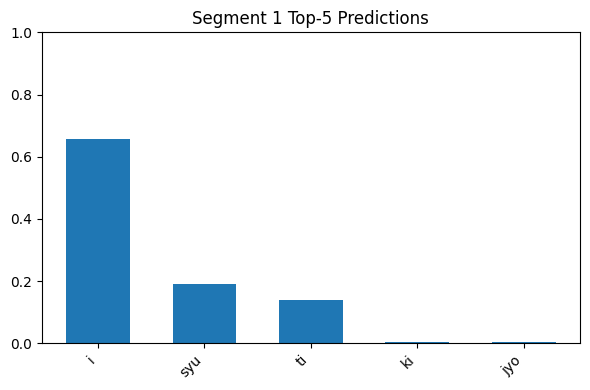

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

--- Segment 2 [5.0–10.0s] ---
▶ RAW (speech_prob=0.000)


  Top-5 Predictions:
           i: 0.684
          ti: 0.171
         syu: 0.144
         jyo: 0.001
          mi: 0.000


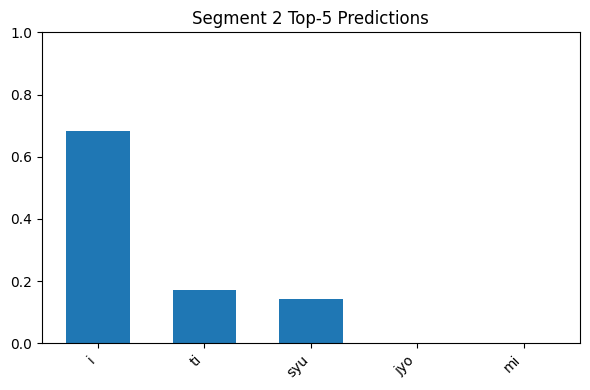

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

--- Segment 3 [10.0–13.0s] ---
▶ RAW (speech_prob=0.000)


  Top-5 Predictions:
          ti: 0.871
         syu: 0.129
         jyu: 0.000
          mu: 0.000
          ki: 0.000


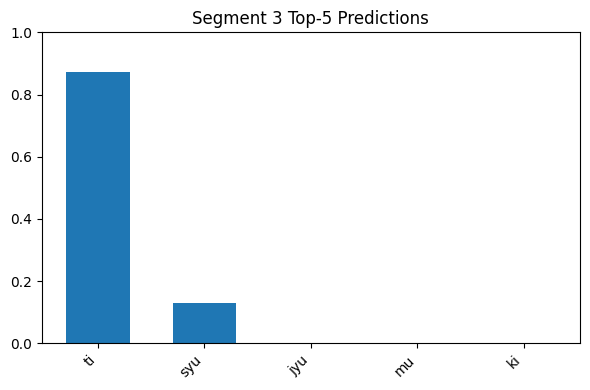

In [1]:
# ───────────────────────────────────────────────────────────────────
# 1) 必要パッケージのインストール（初回のみ）
!pip install -q webrtcvad tensorflow tensorflow-hub librosa soundfile matplotlib

# 2) Google Drive をマウント（必要に応じて）
from google.colab import drive
drive.mount('/content/drive')
# 3) 各種インポート
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import soundfile as sf
from pathlib import Path
from google.colab import files
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)


# 4) 定数設定
TARGET_SR        = 16000    # サンプリングレート
WINDOW_SEC       = 5        # セグメント長［秒］
SPEECH_THRESHOLD = 0.3      # YAMNet の "Speech" 判定閾値
OUT_DIR          = "/content/output_audio_pipeline"
os.makedirs(OUT_DIR, exist_ok=True)
# 5) モデルロード
MODEL_PATH = '/content/drive/MyDrive/finetuned_moraa_model.h5'
print("Loading fine-tuned model…")
ft_model = tf.keras.models.load_model(MODEL_PATH)
print("Loading YAMNet…")
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

# 6) YAMNet クラスマップから “Speech” インデックスを取得
cm_path = yamnet.class_map_path().numpy().decode()
yamnet_labels = open(cm_path, 'r').read().splitlines()
speech_idx = next(i for i,lbl in enumerate(yamnet_labels) if 'speech' in lbl.lower())
print(f"→ YAMNet speech index={speech_idx}, label={yamnet_labels[speech_idx]}")

# 7) Fine-tunedモデルのクラス名リスト取得
TRAIN_ROOT = Path('/content/drive/MyDrive/augmented_backuped')  # 学習データのルート
class_names = sorted([d.name for d in TRAIN_ROOT.iterdir()
                      if d.is_dir() and any(d.glob('*.wav'))])
assert ft_model.output_shape[-1] == len(class_names), "モデル出力数とクラス数が不一致"


# 8) 埋め込み抽出関数 (mean/std/max → 3072次元)
def extract_embedding(y):
    wav = tf.convert_to_tensor(y, tf.float32)
    _, embs, _ = yamnet(wav)          # embs: (frames,1024)
    em = embs.numpy()
    return np.concatenate([em.mean(0), em.std(0), em.max(0)], axis=0)


# 9) 推論パイプライン
print("🔽 推論したい WAV をアップロードしてください")
uploaded = files.upload()
for fn in uploaded:
    print(f"\n===== Processing: {fn} =====")
    audio, _ = librosa.load(fn, sr=TARGET_SR, mono=True)
    total_sec = len(audio) / TARGET_SR
    n_seg     = int(np.ceil(total_sec / WINDOW_SEC))
    base      = os.path.splitext(os.path.basename(fn))[0]

    # 各セグメント（5秒ごと）
    for i in range(n_seg):
        t0, t1 = i*WINDOW_SEC, min((i+1)*WINDOW_SEC, total_sec)
        s, e   = int(t0*TARGET_SR), int(t1*TARGET_SR)
        seg    = audio[s:e]

        # (A) 生セグメントを保存
        path_raw = f"{OUT_DIR}/{base}_seg{i+1}_raw.wav"
        sf.write(path_raw, seg, TARGET_SR)

        # (B) YAMNet で “Speech” 判定 → 非Speech 部分のみ Fine-tuned 推論
        scores, _, _ = yamnet(tf.convert_to_tensor(seg, tf.float32))
        avg_scores   = tf.reduce_mean(scores, axis=0).numpy()
        sp_prob      = float(avg_scores[speech_idx])

        if sp_prob > SPEECH_THRESHOLD:
            # “Speech” 部分と判定 → 推論スキップ
            top5 = []
        else:
            # 非Speech 部分を Fine-tuned モデルで Top-5 取得
            emb  = extract_embedding(seg)[None, :]       # → (1,3072)
            prob = ft_model.predict(emb)[0]               # → (num_classes,)
            top5 = [(class_names[j], float(prob[j]))
                    for j in prob.argsort()[-5:][::-1]]

        # (C) 再生＆テキスト表示
        print(f"\n--- Segment {i+1} [{t0:.1f}–{t1:.1f}s] ---")
        print(f"▶ RAW (speech_prob={sp_prob:.3f})")
        display(Audio(path_raw, rate=TARGET_SR))
        if top5:
            print("  Top-5 Predictions:")
            for cls, sc in top5:
                print(f"    {cls:>8}: {sc:.3f}")
        else:
            print("  [Speech と判定 → 推論スキップ]")

        # (D) グラフで表示（Top-5 が存在するときのみ）
        if top5:
            names = [cls for cls, _ in top5]
            scores_vals = [sc for _, sc in top5]
            x = np.arange(len(names))
            fig, ax = plt.subplots(figsize=(6,4))
            ax.bar(x, scores_vals, 0.6)
            ax.set_xticks(x)
            ax.set_xticklabels(names, rotation=45, ha='right')
            ax.set_ylim(0,1)
            ax.set_title(f"Segment {i+1} Top-5 Predictions")
            plt.tight_layout()
            plt.show()
